### Comparing Mixed Effect Regressions.

I made the observation, that the model estimated by statsmodels.mixedlm procudes different results depending on whether the data is normalized, which shouldn't be the case.  

After trying different settings and reading up on the function, I believe that the problem comes from an incorrect /uninformed setting of random effects. 

I have not observed the scaling problems when using the Lmer library (basically an R library for "linear mixed effects regressions") for fitting logistic regressions.
The aims of this notebook are the following:

0. reviewing mixed effect linear regressions
1. documenting differences between using the Lmer packages and statsmodels
2. understanding the different ways of defining random effects in both libraries
3. finding the right variables to analyse the given data set.


Resources:

Here is the tutorial I followed for the mixed effects regression with statsmodels:

https://www.kaggle.com/ojwatson/mixed-models

Here is a tutorial comparing linear mixed effect models in R an python:

https://jbhender.github.io/Stats506/F18/GP/Group16.html

In [1]:
# Import packages and functions
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy as sp
from scipy import stats

from sklearn import preprocessing
import statsmodels.api as sm
import statsmodels.formula.api as smf

os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['R_HOME'] = 'C:\Program Files\R\R-4.0.3'

import pymer4
from pymer4.models import Lmer, Lm


# load data file and define variable 'answer' (1 = correct answer, 0 = incorrect answer)

data = pd.read_csv('../2_cleaned/long_data.csv')

In [2]:
help(Lmer)

Help on class Lmer in module pymer4.models.Lmer:

class Lmer(builtins.object)
 |  Lmer(formula, data, family='gaussian')
 |  
 |  Model class to hold data outputted from fitting lmer in R and converting to Python object. This class stores as much information as it can about a merMod object computed using lmer and lmerTest in R. Most attributes will not be computed until the fit method is called.
 |  
 |  Args:
 |      formula (str): Complete lmer-style model formula
 |      data (pandas.core.frame.DataFrame): input data
 |      family (string): what distribution family (i.e.) link function to use for the generalized model; default is gaussian (linear model)
 |  
 |  Attributes:
 |      fitted (bool): whether model has been fit
 |      formula (str): model formula
 |      data (pd.DataFrame): model copy of input data
 |      grps (dict): groups and number of observations per groups recognized by lmer
 |      design_matrix (pd.DataFrame): model design matrix determined by lmer
 |      AI

In [3]:
data

,subject,session,pos_t,pin_t,time,goResp,rea_time,in_out,indTrial,in_out_fac,pin_norm,pos_norm,time_norm,pin_resc,pos_resc,time_resc
0,AD,1,0.301258,0.486096,2.0,1,432.42460,1,0,out,-0.010750,-2.697556,-414.51902,-0.025839,-1.296080,-1.456652
1,AD,1,3.225335,0.190052,165.0,1,432.42460,1,0,out,-0.306793,0.226521,-251.51902,-0.737444,0.108835,-0.883858
2,AD,1,2.362545,0.190052,332.0,1,432.42460,1,0,out,-0.306793,-0.636269,-84.51902,-0.737444,-0.305704,-0.297006
3,AD,1,1.703039,0.190052,498.0,1,432.42460,1,0,out,-0.306793,-1.295774,81.48098,-0.737444,-0.622574,0.286331
4,AD,1,0.261664,0.213758,665.0,1,432.42460,1,0,out,-0.283087,-2.737149,248.48098,-0.680462,-1.315103,0.873182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26377,AG,3,3.739433,1.000000,166.0,1,599.60276,-1,8787,in,0.503155,0.740619,-250.51902,1.209441,0.355841,-0.880343
26378,AG,3,2.346879,1.000000,333.0,1,599.60276,-1,8787,in,0.503155,-0.651935,-83.51902,1.209441,-0.313231,-0.293492
26379,AG,3,1.617489,1.000000,500.0,1,599.60276,-1,8787,in,0.503155,-1.381325,83.48098,1.209441,-0.663678,0.293359
26380,AG,3,0.286732,1.000000,666.0,1,599.60276,-1,8787,in,0.503155,-2.712082,249.48098,1.209441,-1.303059,0.876696


In [4]:
data.groupby('subject').describe()

session                                                pos_t  \
          count      mean       std  min  25%  50%  75%  max   count   
subject                                                                
AD       7776.0  1.929012  0.820071  1.0  1.0  2.0  3.0  3.0  7776.0   
AE       6120.0  2.001961  0.821350  1.0  1.0  2.0  3.0  3.0  6120.0   
AF       4290.0  1.481119  0.499702  1.0  1.0  1.0  2.0  2.0  4290.0   
AG       8196.0  1.939239  0.827807  1.0  1.0  2.0  3.0  3.0  8196.0   

                   ...  pos_resc           time_resc                      \
             mean  ...       75%       max     count      mean       std   
subject            ...                                                     
AD       2.998427  ...  0.721821  2.401445    7776.0 -0.000113  0.999975   
AE       3.052389  ...  0.779211  2.401697    6120.0 -0.000104  1.000021   
AF       2.967563  ...  0.681540  2.399797    4290.0 -0.000019  1.000050   
AG       2.994059  ...  0.713255  2.402626    8196.0 -0.000011  1.000019   

                                                          
             min       25%       50%       75%       max  
subject                                                   
AD      -1.46368 -0.880343 -0.001824  0.876696  1.467061  
AE      -1.46368 -0.880343  0.005204  0.876696  1.484631  
AF      -1.46368 -0.880343 -0.000067  0.876696  1.467061  
AG      -1.46368 -0.880343  0.010475  0.876696  1.495173  

[4 rows x 112 columns]

Objective 0: Review Linear Mixed Effect models by computing one by hand

In [5]:
# a linear mixed model is defined as:

# y = Xb + Zu + e
# y is a known vector of known observations with mean E(y) = Xb
# b is an unknown vector of fixed effects
# u is an unknown vector of random effects with mean E(u) = 0 and variance/covariance matrix var(u) = G
# e is an unknown vector of random errors with mean E(e) = 0 and variance var(e) = R
# X and Z are known design matrices relating the observations y to b and u.
# (source: wikipedia)

# simple example: does trial type predict reaction time, with subject as random factor

y = data.rea_time
X = pd.get_dummies(data.in_out_fac)
Z = pd.get_dummies(data.subject)

# let's define a function that computes a prediction for y and returns the summed squared error
def get_pred(x0, X=X, Z=Z):
    off = x0[0]
    b1 = 0
    b2 = x0[1]
    s1 = 0
    s2 = x0[2]
    s3 = x0[3]
    s4 = x0[4]
    y_hat = off+(np.dot(X,[b1,b2]) + np.dot(Z,[s1,s2, s3,s4]))
    
    return y_hat

def get_error(x0, y=y):
    
    y_hat = get_pred(x0)
    error = y - y_hat
    
    return np.sum(error**2) 

# optimize this function such that we get an estimate for the intercept, effect estimates for the two conditions and an estimate 
# for the subject factor
opt = sp.optimize.minimize(get_error, x0 = [500, 1.1,1.4,1.4,1.4], method = 'L-BFGS-B')

In [6]:
# let's see how much variance cannot be explained by our predicition
y_hat = get_pred(opt.x)
y_err = y_hat - y
np.std(y_err)

77.10080956095862

In [7]:
print('the estimated parameters are: {}'.format(opt.x))
print('the remaining summed errors was: {}'.format(opt.fun))

# save the output in a data frame
results_df = pd.DataFrame(columns = ['offset', 'level_out', 'p_in', 'pos', 'time', 's2', 's3', 's4'], index = ['c', 'c_pin', 'c_pin_pos_t'])

results_df.offset['c'] = opt.x[0]
results_df.level_out['c'] = opt.x[1]
results_df.s2['c'] = opt.x[2]
results_df.s3['c'] = opt.x[3]
results_df.s4['c'] = opt.x[4]

the estimated parameters are: [521.1075105   11.84238118  16.49083319 -57.96884194 105.11190034]
the remaining summed errors was: 156828718.0160768


Interpretation: 

The offset for reaction times is 521.107 ms (i.e. the mean rt for the first tratement level -> in and the first participant)

When the treatment changes to "out", reaction times are 11.8 ms longer

For the 2nd participant, reaction times are 16ms longer, for the 3rd 58 ms shorter, for the 4th 105 ms longer

Let's plot this

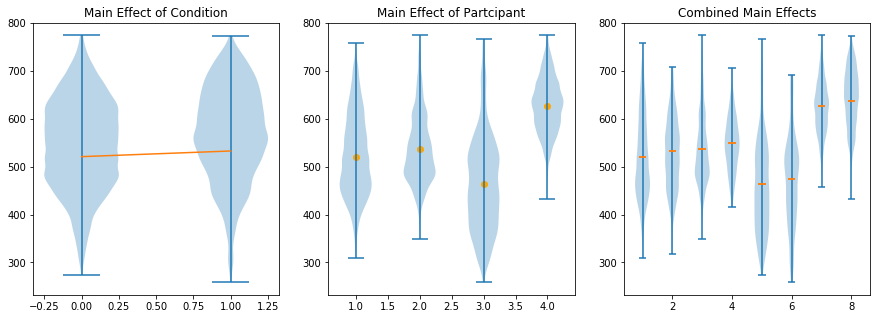

In [8]:
# Plotting the main effects of treatment and participant
fig_manual_condition_participant, axs1 = plt.subplots(1,3, figsize = (15,5))

# axs 1: plot the main effect of condition
in_rts = data[data.in_out_fac == 'in'].rea_time
out_rts = data[data.in_out_fac == 'out'].rea_time

conds = np.array([0,1])

axs1[0].violinplot([in_rts.values, out_rts.values], positions = [0, 1])
axs1[0].plot(conds, opt.x[1]*conds + opt.x[0])
axs1[0].set_title('Main Effect of Condition')


# axs 2: plot the main effect of participant
part_plots = []
for p in np.unique(data.subject):
    part_plots.append(data[data.subject == p].rea_time.values)

axs1[1].violinplot(part_plots);
axs1[1].scatter([1,2,3,4], [0, opt.x[2],opt.x[3], opt.x[4]] + opt.x[0], color = 'orange')
axs1[1].set_title('Main Effect of Partcipant')

# axs 3: plot both main effects at the same time
part_time_plots = []
data['predrt'] = get_pred(opt.x)
pred_part_time_plots = []
for p in np.unique(data.subject):
    for cond in np.unique(data.in_out_fac):
        part_time_plots.append(data[((data.subject == p) & (data.in_out_fac == cond))].rea_time.values)
        pred_part_time_plots.append(data[((data.subject == p) & (data.in_out_fac == cond))].predrt.values)
        
axs1[2].violinplot(part_time_plots)
axs1[2].violinplot(pred_part_time_plots)
axs1[2].set_title('Combined Main Effects');

Conclusion: The best estimate is the mean value of the group we are looking at.

In [9]:
# let's compute the same regression with Lmer

lmer_fit = Lmer('rea_time ~ in_out_fac + (1|subject)', data = data, family = 'gaussian')
lmer_fit.fit()

Formula: rea_time~in_out_fac+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 26382	 Groups: {'subject': 4.0}

Log-likelihood: -152080.100 	 AIC: 304160.200

Random effects:

                 Name       Var     Std
subject   (Intercept)  4555.150  67.492
Residual               5945.662  77.108

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),537.019,470.870,603.168,33.750,3.000,15.912,0.001,***
in_out_facout,11.844,9.286,14.402,1.305,26377.231,9.077,0.000,***


In [10]:
# And the same thing with the python function:

sm_fit = smf.mixedlm('rea_time ~ C(in_out_fac)',data = data, groups = 'subject')
sm_fitted = sm_fit.fit(reml = False)

sm_fitted.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
===================================================================
Model:               MixedLM    Dependent Variable:    rea_time    
No. Observations:    26382      Method:                ML          
No. Groups:          4          Scale:                 5945.4265   
Min. group size:     4290       Log-Likelihood:        -152085.6475
Max. group size:     8196       Converged:             Yes         
Mean group size:     6595.5                                        
-------------------------------------------------------------------
                      Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
-------------------------------------------------------------------
Intercept             537.019   29.388 18.273 0.000 479.419 594.619
C(in_out_fac)[T.out]   11.845    1.305  9.077 0.000   9.287  14.402
subject Var          3453.574   32.032                             
===================================================================

"""

Till here, the results look good - the r function and the python function procude the exact same output, and the hand fitted results are comparable. 
On top of the estimated slope, the Python and R implementation also give us a p-value for the sigificance level of our results. 
Next, we will do a slightly more complicated version by including one more factor into the model.

In [11]:
# Include the new factor (pin_t) by hand

y = data.rea_time

# X has now three levels - the dummy coded factor level and one column with the probability values
X = pd.get_dummies(data.in_out_fac)
X = pd.concat([X, data.pin_t], axis = 1)

Z = pd.get_dummies(data.subject)

# let's define a function that computes a prediction for y and returns the summed squared error
def get_pred2(x0, X=X, Z=Z):
    off = x0[0]
    b1 = 0
    b2 = x0[1]
    b3 = x0[2]
    s1 = 0
    s2 = x0[3]
    s3 = x0[4]
    s4 = x0[5]
    y_hat = off+(np.dot(X,[b1,b2, b3]) + np.dot(Z,[s1,s2, s3,s4]))
    
    return y_hat

def get_error2(x0, y=y):
    
    y_hat = get_pred2(x0)
    error = y - y_hat
    
    return np.mean(error**2) 

# optimize this function such that we get an estimate for the intercept, effect estimates for the two conditions and an estimate 
# for the subject factor
opt2 = sp.optimize.minimize(get_error2, x0 = [500, 0, 1.1,1.4,1.4,1.4], method = 'L-BFGS-B')

In [12]:
print('the standart deviation in this model is {}'.format(np.std(y-get_pred2(opt2.x))))
print('the estimated parameters are {}'.format(opt2.x))

results_df.offset['c_pin'] = opt2.x[0]
results_df.level_out['c_pin'] = opt2.x[1]
results_df.p_in['c_pin'] = opt2.x[2]
results_df.s2['c_pin'] = opt2.x[3]
results_df.s3['c_pin'] = opt2.x[4]
results_df.s4['c_pin'] = opt2.x[5]

results_df

the standart deviation in this model is 76.68825830993714
the estimated parameters are [557.02047927 -15.00734846 -41.04312914  17.285869   -56.87052403
 105.27486323]


,offset,level_out,p_in,pos,time,s2,s3,s4
c,521.108,11.8424,NaN,NaN,NaN,16.4908,-57.9688,105.112
c_pin,557.02,-15.0073,-41.0431,NaN,NaN,17.2859,-56.8705,105.275
c_pin_pos_t,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


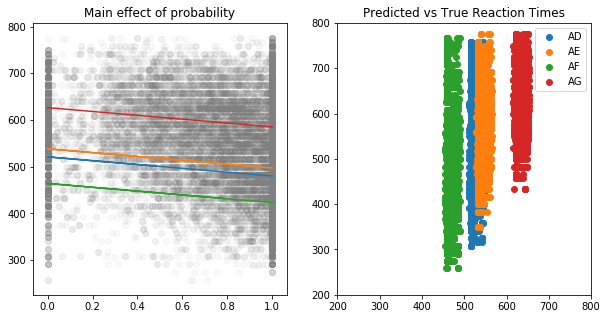

In [13]:
# let's plot the main effect of p_in

fig_manual_probabiliy, axs2 = plt.subplots(1,2, figsize = (10,5))

axs2[0].set_title('Main effect of probability')
data['predrt2'] = get_pred2(opt2.x)
sub_off = [0, opt2.x[3], opt2.x[4], opt2.x[5]]

for pid, p in enumerate(np.unique(data.subject)):
    pdat = data[data.subject == p]
    
    # plot probability against reaction times
    axs2[0].scatter(pdat.pin_t, pdat.rea_time, color = 'grey', alpha = 0.05)
    axs2[0].plot(pdat.pin_t, opt2.x[2]*pdat.pin_t + opt.x[0] + sub_off[pid])
    
    # plot all prediced against all real rts
    axs2[1].scatter(pdat.predrt2,pdat.rea_time, label = p)
    
axs2[1].set_xlim(200,800)
axs2[1].set_ylim(200,800)
axs2[1].set_title('Predicted vs True Reaction Times')
axs2[1].legend();

Conclusion: Reaction times seem faster at high probabilities. The model does a poor job so far in capturing the varability in the response times.

We are not allowing for interaction and slope here, so every slope is the same.

In [14]:
# lets compute the r and the python model

# let's compute the same regression with Lmer

lmer_fit2 = Lmer('rea_time ~ in_out_fac + pin_t + (1|subject)', data = data, family = 'gaussian')
lmer_fit2.fit()

Formula: rea_time~in_out_fac+pin_t+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 26382	 Groups: {'subject': 4.0}

Log-likelihood: -151936.760 	 AIC: 303873.521

Random effects:

                 Name       Var     Std
subject   (Intercept)  4510.373  67.159
Residual               5882.427  76.697

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),573.424,507.465,639.383,33.653,3.025,17.039,0.0,***
in_out_facout,-15.000,-19.025,-10.975,2.053,26376.060,-7.305,0.0,***
pin_t,-41.017,-45.783,-36.252,2.431,26376.034,-16.869,0.0,***


In [15]:
# And the same thing with the python function:

sm_fit2 = smf.mixedlm('rea_time ~ C(in_out_fac) + pin_t',data = data, groups = 'subject')
sm_fitted2 = sm_fit2.fit(reml = False)

sm_fitted2.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
====================================================================
Model:                MixedLM    Dependent Variable:    rea_time    
No. Observations:     26382      Method:                ML          
No. Groups:           4          Scale:                 5881.9710   
Min. group size:      4290       Log-Likelihood:        -151944.1051
Max. group size:      8196       Converged:             Yes         
Mean group size:      6595.5                                        
--------------------------------------------------------------------
                      Coef.   Std.Err.    z    P>|z|  [0.025  0.975]
--------------------------------------------------------------------
Intercept             573.425   29.323  19.556 0.000 515.954 630.897
C(in_out_fac)[T.out]  -15.000    2.053  -7.305 0.000 -19.025 -10.976
pin_t                 -41.018    2.431 -16.870 0.000 -45.783 -36.252
subject Var          3419.542   31.886                              
====================================================================

"""

In [16]:
# still, the models look comparable. Let's try to fit the full model (without interactions)

In [17]:
# full model by hand:

y = data.rea_time
X = pd.get_dummies(data.in_out_fac)
X = pd.concat([X, data.pin_t, data.pos_t, data.time], axis = 1)
Z = pd.get_dummies(data.subject)

def full_pred(x0, X=X, Z=Z):
    
    intercept = x0[0]
    level_in = 0
    level_out = x0[1]
    coef_pin = x0[2]
    coef_pos = x0[3]
    coef_time = x0[4]
    
    sub1 = 0
    sub2 = x0[5]
    sub3 = x0[6]
    sub4 = x0[7]
    
    y_pred = intercept+(np.dot(X,[level_in,level_out,coef_pin,coef_pos, coef_time]) + np.dot(Z,[sub1, sub2, sub3, sub4]))
    
    return y_pred

def full_error(x0, y=y):
    
    y_hat = full_pred(x0)
    error = y_hat - y
    
    return np.mean(error**2)

intercept = 500
level_out = -15
coef_pin = -40
coef_pos = 30
coef_time = 10

sub2 = 12
sub3 = 15
sub4 = -15

full_optim = sp.optimize.minimize(full_error, x0 = [intercept, level_out, coef_pin, coef_pos, coef_time, sub2, sub3, sub4], method = 'L-BFGS-B')

In [18]:
full_optim.x

results_df.offset['c_pin_pos_t'] = full_optim.x[0]
results_df.level_out['c_pin_pos_t'] = full_optim.x[1]
results_df.p_in['c_pin_pos_t'] = full_optim.x[2]
results_df.pos['c_pin_pos_t'] = full_optim.x[3]
results_df.time['c_pin_pos_t'] = full_optim.x[4]
results_df.s2['c_pin_pos_t'] = full_optim.x[5]
results_df.s3['c_pin_pos_t'] = full_optim.x[6]
results_df.s4['c_pin_pos_t'] = full_optim.x[7]

results_df

,offset,level_out,p_in,pos,time,s2,s3,s4
c,521.108,11.8424,NaN,NaN,NaN,16.4908,-57.9688,105.112
c_pin,557.02,-15.0073,-41.0431,NaN,NaN,17.2859,-56.8705,105.275
c_pin_pos_t,540.465,-2.31224,-24.6849,-0.450996,0.00530033,18.6982,-56.621,106.127


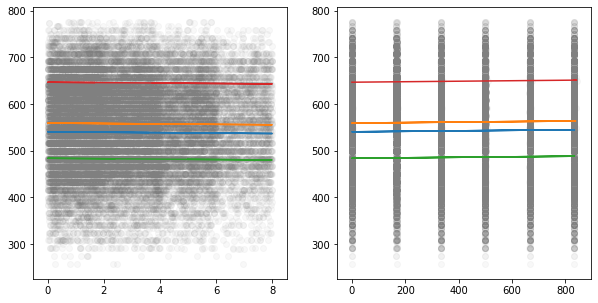

In [19]:
# plot the main effects of position and time
fig_pos_time, axs3 = plt.subplots(1,2, figsize = (10,5))

# 1. plot the effect of position (by subject)
s_offset = [0, full_optim.x[5],full_optim.x[6], full_optim.x[7]]

for pid, p in enumerate(np.unique(data.subject)):
    pdat = data[data.subject == p]
    axs3[0].scatter(pdat.pos_t, pdat.rea_time, alpha = 0.05, color = 'grey')
    axs3[0].plot(pdat.pos_t, pdat.pos_t*full_optim.x[3]+full_optim.x[0]+s_offset[pid])
    
    axs3[1].scatter(pdat.time, pdat.rea_time, alpha = 0.05, color = 'grey')
    axs3[1].plot(pdat.time, pdat.time*full_optim.x[4]+full_optim.x[0]+s_offset[pid])

In [20]:
# The standart deviation here was only minimally reduced. 
# lets compute the r and the python model

# let's compute the same regression with Lmer

lmer_full = Lmer('rea_time ~ in_out_fac + pin_t + pos_t + time + (1|subject)', data = data, family = 'gaussian')
lmer_full.fit()

Formula: rea_time~in_out_fac+pin_t+pos_t+time+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 26382	 Groups: {'subject': 4.0}

Log-likelihood: -151929.336 	 AIC: 303858.672

Random effects:

                 Name       Var     Std
subject   (Intercept)  4508.252  67.144
Residual               5876.879  76.661

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),575.205,509.243,641.168,33.655,3.029,17.091,0.000,***
in_out_facout,-16.851,-20.947,-12.754,2.090,26374.056,-8.062,0.000,***
pin_t,-43.835,-48.742,-38.928,2.504,26374.036,-17.508,0.000,***
pos_t,-0.727,-1.172,-0.283,0.227,26374.002,-3.210,0.001,**
time,0.007,0.004,0.010,0.002,26374.002,4.088,0.000,***


In [21]:
sm_fit2 = smf.mixedlm('rea_time ~ C(in_out_fac) + pin_t + pos_t + time',data = data, groups = 'subject')
sm_fitted2 = sm_fit2.fit(reml = False)

sm_sum = sm_fitted2.summary()
sm_sum

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
====================================================================
Model:                MixedLM    Dependent Variable:    rea_time    
No. Observations:     26382      Method:                ML          
No. Groups:           4          Scale:                 5875.9783   
Min. group size:      4290       Log-Likelihood:        -151930.6598
Max. group size:      8196       Converged:             Yes         
Mean group size:      6595.5                                        
--------------------------------------------------------------------
                      Coef.   Std.Err.    z    P>|z|  [0.025  0.975]
--------------------------------------------------------------------
Intercept             575.207   29.327  19.614 0.000 517.727 632.687
C(in_out_fac)[T.out]  -16.850    2.090  -8.063 0.000 -20.947 -12.754
pin_t                 -43.836    2.503 -17.510 0.000 -48.742 -38.929
pos_t                  -0.727    0.227  -3.210 0.001  -1.172  -0.283
time                    0.007    0.002   4.088 0.000   0.004   0.010
subject Var          3417.899   31.887                              
====================================================================

"""

### understand error margins and the effect of degrees of freedom

Both models here show comparable results to the hand computed model. The effects of position and time are tiny, yet they seem to be significant, which is quite surprising. We will plot the standart errors and compute the T statistics by hand. One hypothesis we test is that the high number of degrees of freedom is artificially driving the significante of the p-value.

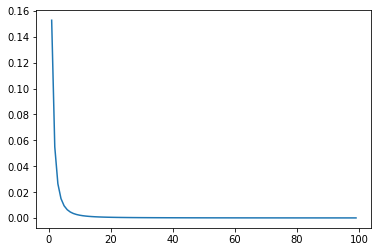

In [22]:
# First, we compute the t-statistics of time ourselves:
# The t-statistics is computed as (b1(observed slope) - 0 (slope of the null hypothesis))/SE(standart error)

# so in this case:
t_time = sm_fitted2.params.time/sm_fitted2.bse.time

# get residual degrees of freedom
re_df = sm_fitted2.df_resid

# check how much the p value changes for different degrees of freedom

dfs = range(0,10)
p_table = [] 
for df in dfs:
    pval = stats.t.sf(np.abs(t_time), df)*2
    p_table.append([df, pval])
p_table.append([re_df,stats.t.sf(np.abs(t_time), df)*2])

plot_dfs = range(0,100)
plot_p_table = []
for df in plot_dfs:
    pval = stats.t.sf(np.abs(t_time), df)*2
    plot_p_table.append([df, pval])

plot_table = pd.DataFrame(np.array(plot_p_table), columns = ['df','p'])
plt.plot(plot_table.df,plot_table.p);

In [23]:
p_table = pd.DataFrame(np.array(p_table), columns = ['df', 'p'])
p_table

,df,p
0,0.0,NaN
1,1.0,0.152724
2,2.0,0.054948
3,3.0,0.026451
4,4.0,0.014998
5,5.0,0.009464
6,6.0,0.006443
7,7.0,0.004642
8,8.0,0.003494
9,9.0,0.002725


It is correct that more degrees of freedom result in a lower p-value. However, this only makes a difference in the interpretation with 2 or less degrees of freedom, so it's not the reason why we see unrealistic p-values here.

The next idea we can test is that for some reasons the standart error is underestimated.

The formula for computing the standard error of a regression slope is:

sb1 = sqrt [ Σ(yi – ŷi)\*\*2 / (n – 2) ] / sqrt [ Σ(xi – x)\*\*2 ].

In [24]:
# compute the standard error for the slope of time

pred_rea_time07 = data.time*sm_fitted2.params.time+sm_fitted2.params.Intercept
pred_rea_time0 = data.time*0+sm_fitted2.params.Intercept

var_y07 = np.sqrt(sum((data.rea_time - pred_rea_time07)**2)/(re_df))
var_x = np.sqrt(np.sum((data.time - np.mean(data.time))**2))

SE_slope07 = var_y07/var_x

# compute the same standard error for a "0" slope
var_y0 = np.sqrt(sum((data.rea_time - pred_rea_time0)**2)/(re_df))

SE_slope0 = var_y0/var_x


print('The standard error for the 0.007 slope was : {}'.format(SE_slope07))
print('The standard error for the 0.000 slope was : {}'.format(SE_slope0))

The standard error for the 0.007 slope was : 0.002173968489614673
The standard error for the 0.000 slope was : 0.0021568424628901402


In [25]:
# The standard error of the slope is smaller when we don't include time as a predictor.
# That could mean that a model with time should perform better than a model without time

# The standart deviation here was only minimally reduced. 
# lets compute the r and the python model

# let's compute the same regression with Lmer

lmer_time = Lmer('rea_time ~ time + (1|subject)', data = data, family = 'gaussian')
lmer_timef = lmer_time.fit();

lmer_subject = Lmer('rea_time ~ 1 + (1|subject)', data = data, family = 'gaussian')
lmer_subjectf = lmer_subject.fit();

sm_time = smf.mixedlm('rea_time ~ time',data = data, groups = 'subject')
sm_timef = sm_time.fit(reml = False)

sm_subject = smf.mixedlm('rea_time ~ 1',data = data, groups = 'subject')
sm_subjectf = sm_subject.fit();

Formula: rea_time~time+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 26382	 Groups: {'subject': 4.0}

Log-likelihood: -152127.891 	 AIC: 304255.781

Random effects:

                 Name       Var     Std
subject   (Intercept)  4589.914  67.749
Residual               5964.227  77.228

No random effect correlations specified

Fixed effects:

Formula: rea_time~1+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 26382	 Groups: {'subject': 4.0}

Log-likelihood: -152122.415 	 AIC: 304244.830

Random effects:

                 Name       Var     Std
subject   (Intercept)  4589.915  67.749
Residual               5964.001  77.227

No random effect correlations specified

Fixed effects:



In [26]:
# Look at the output

sm_timef.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
==========================================================
Model:            MixedLM Dependent Variable: rea_time    
No. Observations: 26382   Method:             ML          
No. Groups:       4       Scale:              5963.9913   
Min. group size:  4290    Log-Likelihood:     -152126.7815
Max. group size:  8196    Converged:          Yes         
Mean group size:  6595.5                                  
----------------------------------------------------------
             Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
----------------------------------------------------------
Intercept    538.854   29.506 18.262 0.000 481.023 596.686
time          -0.000    0.002 -0.000 1.000  -0.003   0.003
subject Var 3479.569   32.219                             
==========================================================

"""

In [27]:
lmer_timef

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),538.854,472.440,605.267,33.885,3.003,15.902,0.001,***
time,-0.000,-0.003,0.003,0.002,26377.000,-0.000,1.000,


Conclusion: only including time as a predictor erases the effect of time. So maybe, the time effect comes from a weird interaction with one of the other variables. We will build the model gradually, adding one factor after another. For this purpose, we will only use the LMER package

In [28]:
lmer_null = Lmer('rea_time ~ 1 + (1|subject)', data = data, family = 'gaussian')
lmer_nullf = lmer_null.fit();

lmer_time = Lmer('rea_time ~ time + (1|subject)', data = data, family = 'gaussian')
lmer_timef = lmer_time.fit();

lmer_time_pos = Lmer('rea_time ~ time + pos_t + (1|subject)', data = data, family = 'gaussian')
lmer_time_posf = lmer_time_pos.fit();

lmer_time_pin = Lmer('rea_time ~ time + pin_t + (1|subject)', data = data, family = 'gaussian')
lmer_time_pinf = lmer_time_pin.fit();

lmer_time_cond = Lmer('rea_time ~ time + in_out_fac + (1|subject)', data = data, family = 'gaussian')
lmer_time_condf = lmer_time_cond.fit();



Formula: rea_time~1+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 26382	 Groups: {'subject': 4.0}

Log-likelihood: -152122.415 	 AIC: 304244.830

Random effects:

                 Name       Var     Std
subject   (Intercept)  4589.915  67.749
Residual               5964.001  77.227

No random effect correlations specified

Fixed effects:

Formula: rea_time~time+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 26382	 Groups: {'subject': 4.0}

Log-likelihood: -152127.891 	 AIC: 304255.781

Random effects:

                 Name       Var     Std
subject   (Intercept)  4589.914  67.749
Residual               5964.227  77.228

No random effect correlations specified

Fixed effects:

Formula: rea_time~time+pos_t+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 26382	 Groups: {'subject': 4.0}

Log-likelihood: -152125.856 	 AIC: 304251.713

Random effects:

                 Name       Var     Std
subject

In [29]:
lmer_nullf

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),538.853,472.454,605.253,33.878,3.0,15.906,0.001,***


In [30]:
lmer_timef

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),538.854,472.440,605.267,33.885,3.003,15.902,0.001,***
time,-0.000,-0.003,0.003,0.002,26377.000,-0.000,1.000,


In [31]:
lmer_time_posf

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),540.426,473.994,606.858,33.895,3.005,15.944,0.001,***
time,-0.000,-0.003,0.003,0.002,26376.000,-0.019,0.985,
pos_t,-0.519,-0.966,-0.072,0.228,26376.002,-2.278,0.023,*


In [32]:
lmer_time_pinf

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),558.903,493.058,624.747,33.595,3.009,16.637,0.000,***
time,0.004,0.001,0.008,0.002,26376.005,2.657,0.008,**
pin_t,-27.867,-30.915,-24.818,1.555,26376.211,-17.916,0.000,***


In [33]:
lmer_time_condf

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),537.019,470.855,603.182,33.757,3.003,15.908,0.001,***
time,-0.000,-0.003,0.003,0.002,26376.000,-0.000,1.000,
in_out_facout,11.844,9.286,14.402,1.305,26376.231,9.076,0.000,***


This shows us, that time gets an influence, when we include position into the model. Let's try and plot that effect

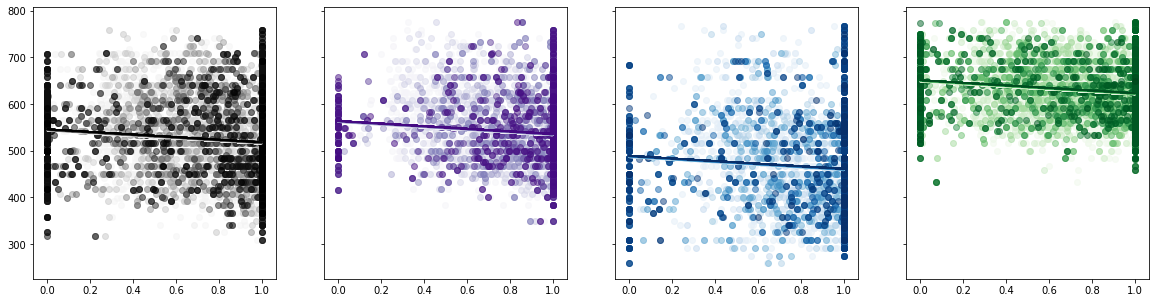

In [34]:
fig_rt_by_time_and_pin, axs4 = plt.subplots(1,4, figsize = (20,5), sharex= True, sharey=True)

cmaps = [plt.cm.Greys,plt.cm.Purples,plt.cm.Blues,plt.cm.Greens]
sub_intercept = lmer_time_pin.fixef['(Intercept)']

for pid, p in enumerate(np.unique(data.subject)):
    cmap = cmaps[pid]
    pdat = data[data.subject == p]
    
    tps = np.unique(pdat.time)
    cvals = cmap(np.linspace(0,1,len(tps)+2))[2:]
    for t,c in zip(tps,cvals):
        tdat = pdat[pdat.time == t]
        rt_est = tdat.time.values*lmer_time_pinf.Estimate['time']+tdat.pin_t.values*lmer_time_pinf.Estimate['pin_t'] + sub_intercept[pid]
        axs4[pid].scatter(tdat.pin_t, tdat.rea_time, color = c, alpha = 0.5)
        axs4[pid].plot(tdat.pin_t, rt_est, color = c)
        

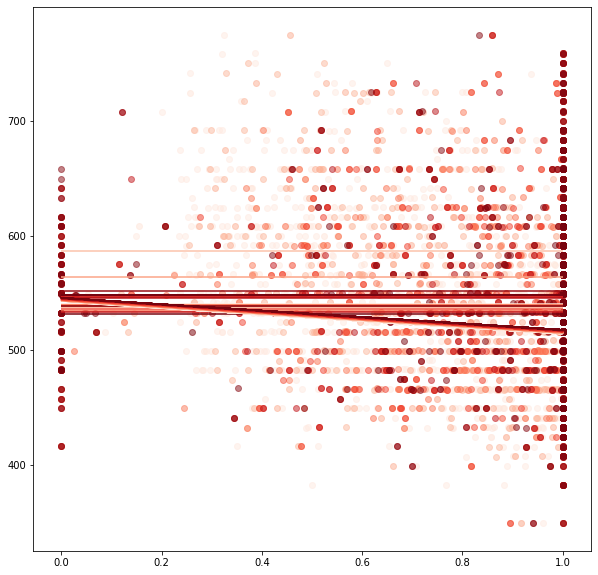

In [35]:
# let's zoom in on one of these plots
fig_zoom_1part, axs5 = plt.subplots(1,1, figsize = (10,10))
p = 'AE'
pdat = data[data.subject == p]

tps = np.unique(pdat.time)
cvals = plt.cm.Reds(np.linspace(0,1,len(tps)+2))[2:]
for t,c in zip(tps,cvals):
    tdat = pdat[pdat.time == t]
    rt_est = tdat.time.values*lmer_time_pinf.Estimate['time']+tdat.pin_t.values*lmer_time_pinf.Estimate['pin_t'] + sub_intercept[0]
    axs5.scatter(tdat.pin_t, tdat.rea_time, color = c, alpha = 0.5)
    axs5.plot(tdat.pin_t, rt_est, color = c)  
    axs5.hlines(np.mean(tdat.rea_time),0,1, color = c)

In [36]:
# idea 1: the timing varies - that could explain the effect

# correction : round the time values
data['round_time'] = np.round(data.time,-2)

In [37]:
lmer_time_r_pin = Lmer('rea_time ~ round_time + pin_t + (1|subject)', data = data, family = 'gaussian')
lmer_time_r_pinf = lmer_time_r_pin.fit()
lmer_time_r_pinf

Formula: rea_time~round_time+pin_t+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 26382	 Groups: {'subject': 4.0}

Log-likelihood: -151966.958 	 AIC: 303933.917

Random effects:

                 Name       Var     Std
subject   (Intercept)  4506.550  67.131
Residual               5892.743  76.764

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),558.865,493.021,624.710,33.595,3.010,16.635,0.000,***
round_time,0.005,0.001,0.008,0.002,26376.005,2.663,0.008,**
pin_t,-27.869,-30.918,-24.821,1.555,26376.211,-17.917,0.000,***


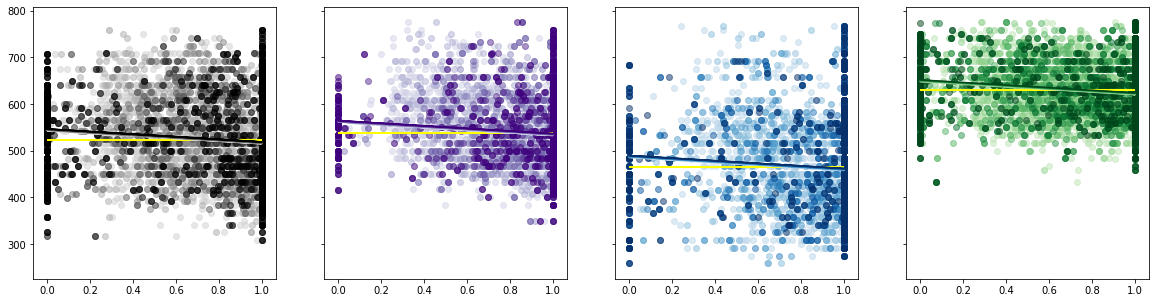

In [38]:
# let's make the same plots for rounded times, including the mean line
fig_zoom_round, axs6 = plt.subplots(1,4, figsize = (20,5), sharex = True, sharey = True)

cmaps = [plt.cm.Greys,plt.cm.Purples,plt.cm.Blues,plt.cm.Greens]
sub_intercept = lmer_time_r_pin.fixef['(Intercept)']

for pid, p in enumerate(np.unique(data.subject)):
    cmap = cmaps[pid]
    pdat = data[data.subject == p]
    
    tps = np.unique(pdat.round_time)
    cvals = cmap(np.linspace(0,1,len(tps)+2))[2:]
    for t,c in zip(tps,cvals):
        tdat = pdat[pdat.round_time == t]
        rt_est = tdat.round_time.values*lmer_time_r_pinf.Estimate['round_time']+tdat.pin_t.values*lmer_time_r_pinf.Estimate['pin_t'] + sub_intercept[pid]
        axs6[pid].scatter(tdat.pin_t, tdat.rea_time, color = c, alpha = 0.5)
        axs6[pid].plot(tdat.pin_t, rt_est, color = c)
        axs6[pid].hlines(np.mean(tdat.rea_time),0,1, color = 'yellow')

Formula: rea_time~time+pin_t

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 7776	 R^2: 0.011	 R^2_adj: 0.011

Log-likelihood: -45530.252 	 AIC: 91066.504	 BIC: 91087.381

Fixed effects:

Formula: rea_time~time+pin_t

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 6120	 R^2: 0.021	 R^2_adj: 0.020

Log-likelihood: -34833.510 	 AIC: 69673.019	 BIC: 69693.177

Fixed effects:

Formula: rea_time~time+pin_t

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 4290	 R^2: 0.005	 R^2_adj: 0.005

Log-likelihood: -25809.185 	 AIC: 51624.370	 BIC: 51643.462

Fixed effects:

Formula: rea_time~time+pin_t

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 8196	 R^2: 0.019	 R^2_adj: 0.019

Log-likelihood: -4468

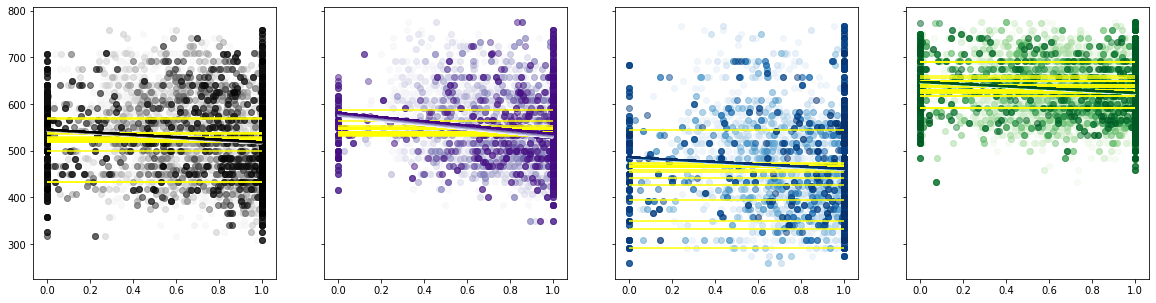

In [39]:
# now, the mean reaction times all fall on one line. However, the model STILL predicts lower rts for early time points. 
# another problem can be, that probability is correlated with time, and that different participants actually had different 
# probabilities associated with the time points. 

# so, to take this eve none step back, we will now fit this model for each participant individually
fig_individual_fit, axs7 = plt.subplots(1,4, figsize = (20,5), sharex = True, sharey = True)

cmaps = [plt.cm.Greys,plt.cm.Purples,plt.cm.Blues,plt.cm.Greens]
parts = np.unique(data.subject)

tests = []

for pid, p in enumerate(parts):
    
    pdat = data[data.subject == p]
    cmap = cmaps[pid]
    # fit the time model for this participant
    lm_part = Lm('rea_time ~ time + pin_t ', data = pdat, family = 'gaussian')
    lm_partf = lm_part.fit()
    tests.append(lm_partf)
    tps = np.unique(pdat.time)
    cvals = cmap(np.linspace(0,1,len(tps)+2))[2:]
    
    for t,c in zip(tps,cvals):
        tdat = pdat[pdat.time == t]
        
        rt_est = tdat.time.values*lm_partf.Estimate['time']+tdat.pin_t.values*lm_partf.Estimate['pin_t'] + lm_partf.Estimate['Intercept']
        axs7[pid].scatter(tdat.pin_t, tdat.rea_time, alpha = 0.5, color = c)
        axs7[pid].plot(tdat.pin_t, rt_est, color = c)
        axs7[pid].hlines(np.mean(tdat.rea_time),0,1, color = 'yellow')

In [40]:
tests

[           Estimate   2.5_ci  97.5_ci     SE    DF   T-stat  P-val  Sig
 Intercept   541.870  536.721  547.019  2.627  7773  206.298  0.000  ***
 time          0.004   -0.002    0.011  0.003  7773    1.249  0.212     
 pin_t       -27.013  -32.745  -21.281  2.924  7773   -9.238  0.000  ***,
            Estimate   2.5_ci  97.5_ci     SE    DF   T-stat  P-val  Sig
 Intercept   572.530  565.847  579.214  3.409  6117  167.934  0.000  ***
 time          0.010    0.003    0.016  0.003  6117    2.903  0.004   **
 pin_t       -44.879  -52.600  -37.157  3.939  6117  -11.393  0.000  ***,
            Estimate   2.5_ci  97.5_ci     SE    DF   T-stat  P-val  Sig
 Intercept   483.401  474.159  492.643  4.714  4287  102.544  0.000  ***
 time          0.003   -0.007    0.014  0.005  4287    0.586  0.558     
 pin_t       -24.643  -34.791  -14.495  5.176  4287   -4.761  0.000  ***,
            Estimate   2.5_ci  97.5_ci     SE    DF   T-stat  P-val  Sig
 Intercept   644.957  641.629  648.285  1.698  8

Formula: rea_time~time*pin_t

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 7776	 R^2: 0.021	 R^2_adj: 0.021

Log-likelihood: -45489.450 	 AIC: 90986.899	 BIC: 91014.734

Fixed effects:

Formula: rea_time~time*pin_t

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 6120	 R^2: 0.034	 R^2_adj: 0.034

Log-likelihood: -34790.785 	 AIC: 69589.569	 BIC: 69616.447

Fixed effects:

Formula: rea_time~time*pin_t

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 4290	 R^2: 0.014	 R^2_adj: 0.014

Log-likelihood: -25789.414 	 AIC: 51586.827	 BIC: 51612.283

Fixed effects:

Formula: rea_time~time*pin_t

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 8196	 R^2: 0.020	 R^2_adj: 0.019

Log-likelihood: -4468

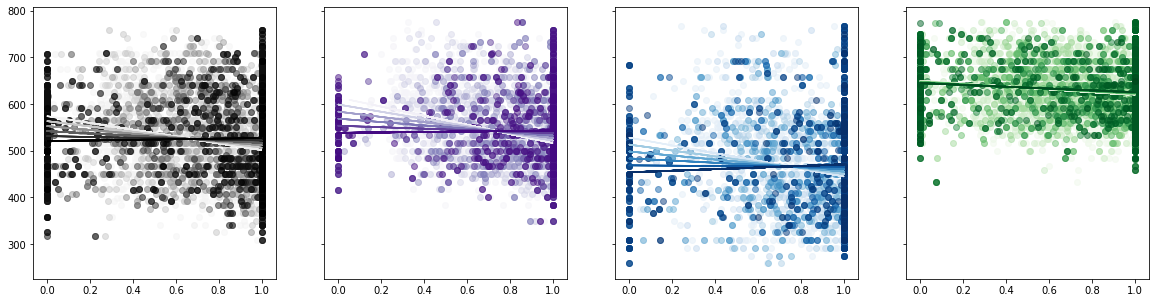

In [41]:
# As we see here, there is one participant, driving the effect, but the slopes and p-values for the other subjects are also not neglectable. 
# (At least, they are way bigger than we would expect here). 
# These plots show, that probability is correlated with reaction times. 
# Time itself is not correlated with reaction times. 
# BUT: time is correlated with probability and we strongly expect an interaction between them. 

# Therefore: let's include the interaction term into the model:

# so, to take this eve none step back, we will now fit this model for each participant individually
fig_individual_interaction_fit, axs8 = plt.subplots(1,4, figsize = (20,5), sharex = True, sharey = True)

cmaps = [plt.cm.Greys,plt.cm.Purples,plt.cm.Blues,plt.cm.Greens]
parts = np.unique(data.subject)

tests = []

for pid, p in enumerate(parts):
    
    pdat = data[data.subject == p]
    cmap = cmaps[pid]
    # fit the time model for this participant
    lm_part = Lm('rea_time ~time * pin_t', data = pdat, family = 'gaussian')
    lm_partf = lm_part.fit()
    tests.append(lm_partf)
    tps = np.unique(pdat.time)
    cvals = cmap(np.linspace(0,1,len(tps)+2))[2:]
    
    for t,c in zip(tps,cvals):
        tdat = pdat[pdat.time == t]
        
        rt_est = tdat.time.values*lm_partf.Estimate['time']+tdat.pin_t.values*lm_partf.Estimate['pin_t'] + lm_partf.Estimate['Intercept'] + lm_partf.Estimate['time:pin_t']*tdat.time.values*tdat.pin_t.values
        axs8[pid].scatter(tdat.pin_t, tdat.rea_time, alpha = 0.5, color = c)
        axs8[pid].plot(tdat.pin_t, rt_est, color = c)
        #axs8[pid].hlines(np.mean(tdat.rea_time),0,1, color = 'yellow')

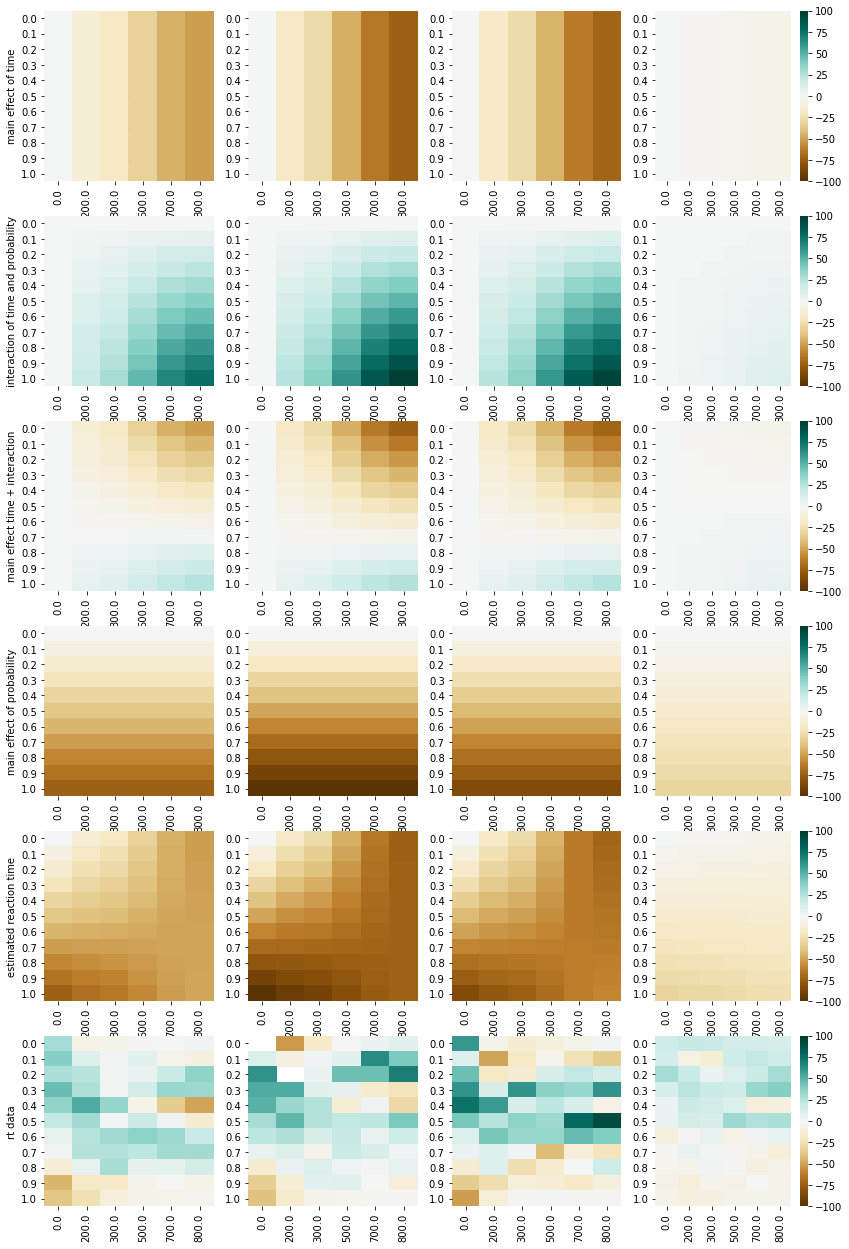

In [42]:
#Heatmaps
fig_heatmaps, axs9 = plt.subplots(6,4, figsize = (14,22))
data['round_pin'] =  np.round(data.pin_t, 1)

for pid,p in enumerate(parts):
    
    pdat = data[data.subject == p]
    pins = np.unique(pdat.round_pin)
    tims = np.unique(pdat.round_time)
    
    test = tests[pid]
    
    hm = pd.DataFrame(np.zeros([len(pins),len(tims)]), index = pins, columns = tims)
    hm_est = pd.DataFrame(np.zeros([len(pins),len(tims)]), index = pins, columns = tims)
    hm_tim = pd.DataFrame(np.zeros([len(pins),len(tims)]), index = pins, columns = tims)
    hm_pin = pd.DataFrame(np.zeros([len(pins),len(tims)]), index = pins, columns = tims)
    hm_int = pd.DataFrame(np.zeros([len(pins),len(tims)]), index = pins, columns = tims)
    
    
    mean_rt = np.mean(pdat.rea_time)
    
    for pin in pins:
        for tim in tims:
            
            hm.loc[pin,tim] = np.mean(pdat[(pdat.round_time== tim) & (pdat.round_pin == pin)].rea_time)-mean_rt
            hm_est.loc[pin,tim] = tim*test.Estimate['time']+ pin*test.Estimate['pin_t'] + test.Estimate['time:pin_t']*tim*pin
            hm_int.loc[pin,tim] = test.Estimate['time:pin_t']*tim*pin
            hm_tim.loc[pin,tim] = tim*test.Estimate['time']
            hm_pin.loc[pin,tim] = pin*test.Estimate['pin_t']
            
    
    sns.heatmap(hm_tim, vmin=-100, vmax=100, ax = axs9[0,pid], cbar = (pid == 3), cmap = plt.cm.BrBG)
    sns.heatmap(hm_int, vmin=-100, vmax=100, ax = axs9[1,pid], cbar = (pid == 3), cmap = plt.cm.BrBG)
    sns.heatmap((hm_int + hm_tim), vmin=-100, vmax=100, ax = axs9[2,pid], cbar = (pid == 3), cmap = plt.cm.BrBG)   
    sns.heatmap(hm_pin, vmin=-100, vmax=100, ax = axs9[3,pid], cbar = (pid == 3), cmap = plt.cm.BrBG)
    sns.heatmap(hm_est, vmin=-100, vmax=100, ax = axs9[4,pid], cbar = (pid == 3), cmap = plt.cm.BrBG)
    sns.heatmap(hm, vmin=-100, vmax=100, ax = axs9[5,pid], cbar = (pid== 3), cmap = plt.cm.BrBG)

axs9[0,0].set_ylabel('main effect of time')
axs9[1,0].set_ylabel('interaction of time and probability')
axs9[2,0].set_ylabel('main effect time + interaction')
axs9[3,0].set_ylabel('main effect of probability')
axs9[4,0].set_ylabel('estimated reaction time')
axs9[5,0].set_ylabel('rt data');


boundary (singular) fit: see ?isSingular 

Formula: rea_time~pin_c*time_c+(1+pin_c*time_c|subject)

Family: gaussian	 Inference: parametric

Number of observations: 26382	 Groups: {'subject': 4.0}

Log-likelihood: -151872.748 	 AIC: 303745.496

Random effects:

                  Name        Var      Std
subject    (Intercept)  11208.779  105.872
subject          pin_c   2372.853   48.712
subject         time_c      0.000    0.022
subject   pin_c:time_c    865.209   29.414
Residual                 5834.536   76.384

                 IV1           IV2   Corr
subject  (Intercept)         pin_c  0.225
subject  (Intercept)        time_c -0.221
subject  (Intercept)  pin_c:time_c -0.000
subject        pin_c        time_c -1.000
subject        pin_c  pin_c:time_c  0.001
subject       time_c  pin_c:time_c -0.001

Fixed effects:



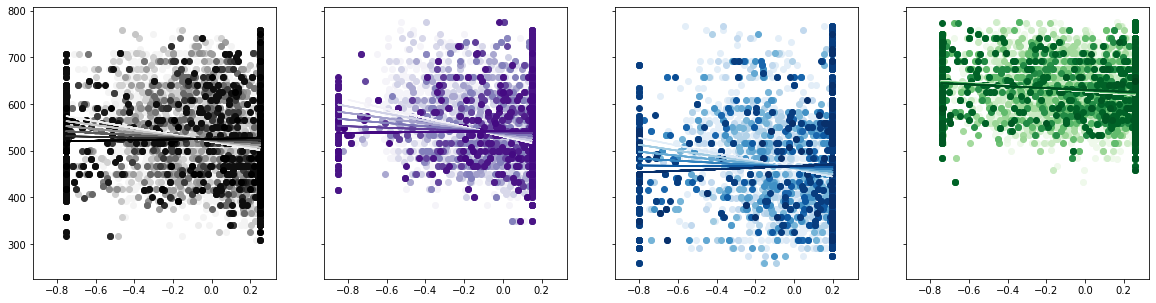

In [43]:
# so what happens here is that the interaction acts upon the offset introduced by the main effect of time.
# hypothesis: because the interaction starts at 0, but we want the center where our lines collaps to be at the mean value,
# this is induced by the time-based offset. Centering probability around it's mean might solve this issue.

fig_centered_interaction_fit, axs10 = plt.subplots(1,4, figsize = (20,5), sharex = True, sharey = True)

cmaps = [plt.cm.Greys,plt.cm.Purples,plt.cm.Blues,plt.cm.Greens]
parts = np.unique(data.subject)

for p in parts:
    pdat = data[data.subject == p]
    data.loc[pdat.index, 'pin_c'] = pdat.pin_t - np.mean(pdat.pin_t)
    data.loc[pdat.index, 'time_c'] = pdat.time - np.mean(pdat.time)


lmer_center = Lmer('rea_time ~ pin_c * time_c + (1+pin_c*time_c|subject)', data = data, family = 'gaussian')
lmer_centerf = lmer_center.fit()

sub_intercept = lmer_center.fixef['(Intercept)'][0]

for pid, p in enumerate(parts):
    
    pdat = data[data.subject == p]
    cmap = cmaps[pid]

    tps = np.unique(pdat.time)
    cvals = cmap(np.linspace(0,1,len(tps)+2))[2:]
    
    for t,c in zip(tps,cvals):
        tdat = pdat[pdat.time == t]
        
        rt_est = lmer_center.fixef['(Intercept)'][pid]+tdat.time_c.values*lmer_center.fixef['time_c'][pid] + tdat.pin_c.values*lmer_center.fixef['pin_c'][pid] + lmer_center.fixef['pin_c:time_c'][pid]*tdat.time_c.values*tdat.pin_c.values
        axs10[pid].plot(tdat.pin_c, rt_est, color = c)
        axs10[pid].scatter(tdat.pin_c, tdat.rea_time, color = c)

In [44]:
lmer_centerf

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),537.666,433.910,641.423,52.938,0.353,10.157,0.299,
pin_c,-34.296,-82.154,13.563,24.418,20.107,-1.405,0.175,
time_c,0.008,-0.014,0.029,0.011,1.350,0.703,0.583,
pin_c:time_c,0.088,-28.738,28.913,14.707,2354.902,0.006,0.995,


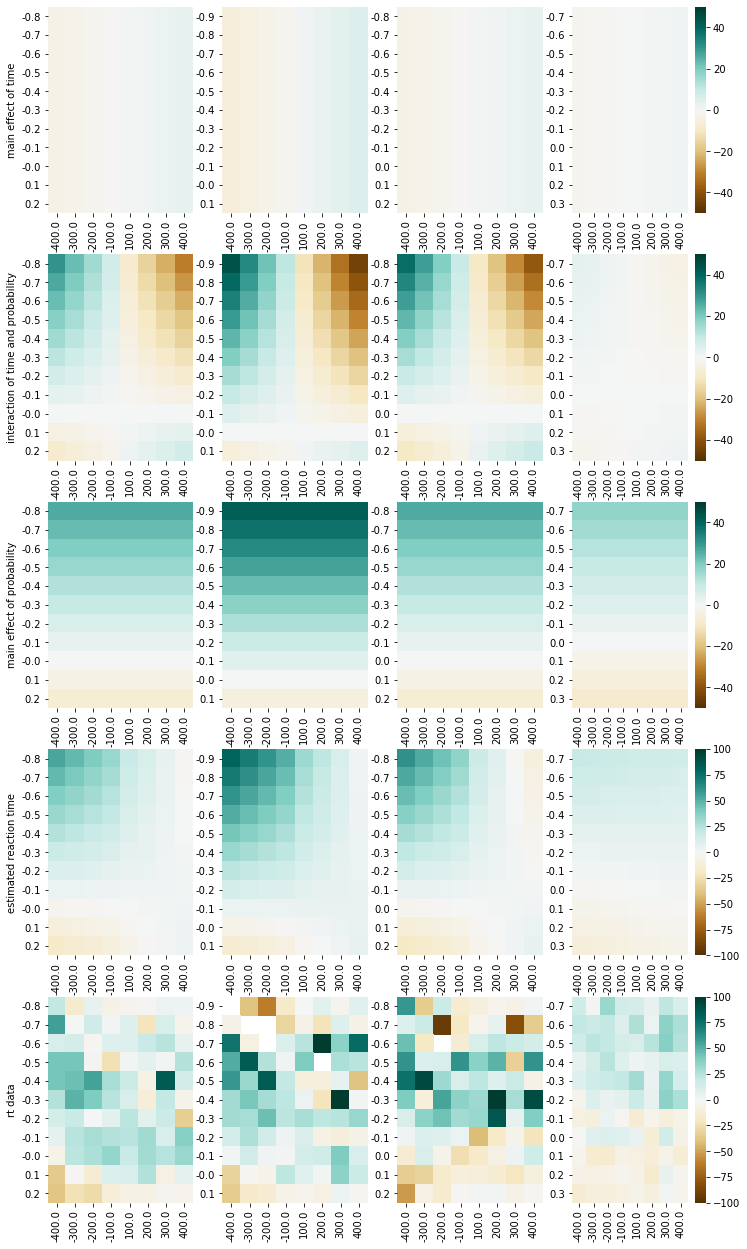

In [45]:
# Heatmaps for the full model

fig_full_mod_heatmaps, axs11 = plt.subplots(5,4, figsize = (12,22))

data['round_pin_c'] =  np.round(data.pin_c, 1)
data['round_tim_c'] =  np.round(data.time_c, -2)

for pid,p in enumerate(parts):
    
    pdat = data[data.subject == p]
    pins = np.unique(pdat.round_pin_c)
    tims = np.unique(pdat.round_tim_c)
    
    c_hm = pd.DataFrame(np.zeros([len(pins),len(tims)]), index = pins, columns = tims)
    c_hm_est = pd.DataFrame(np.zeros([len(pins),len(tims)]), index = pins, columns = tims)
    c_hm_tim = pd.DataFrame(np.zeros([len(pins),len(tims)]), index = pins, columns = tims)
    c_hm_pin = pd.DataFrame(np.zeros([len(pins),len(tims)]), index = pins, columns = tims)
    c_hm_int = pd.DataFrame(np.zeros([len(pins),len(tims)]), index = pins, columns = tims)
    
    
    mean_rt = np.mean(pdat.rea_time)
    
    for pin in pins:
        for tim in tims:
            
            c_hm.loc[pin,tim] = np.mean(pdat[(pdat.round_tim_c== tim) & (pdat.round_pin_c == pin)].rea_time) - mean_rt
            c_hm_est.loc[pin,tim] = tim*lmer_center.fixef['time_c'][pid]+ pin*lmer_center.fixef['pin_c'][pid] + lmer_center.fixef['pin_c:time_c'][pid]*tim*pin
            c_hm_int.loc[pin,tim] = lmer_center.fixef['pin_c:time_c'][pid]*tim*pin
            c_hm_tim.loc[pin,tim] = tim*lmer_center.fixef['time_c'][pid]
            c_hm_pin.loc[pin,tim] = pin*lmer_center.fixef['pin_c'][pid]
            
    
    sns.heatmap(c_hm_tim, vmin=-50, vmax=50, ax = axs11[0,pid], cbar = (pid == 3), cmap = plt.cm.BrBG)
    sns.heatmap(c_hm_int, vmin=-50, vmax=50, ax = axs11[1,pid], cbar = (pid == 3), cmap = plt.cm.BrBG)  
    sns.heatmap(c_hm_pin, vmin=-50, vmax=50, ax = axs11[2,pid], cbar = (pid == 3), cmap = plt.cm.BrBG)
    sns.heatmap(c_hm_est, vmin=-100, vmax=100, ax = axs11[3,pid], cbar = (pid == 3), cmap = plt.cm.BrBG)
    sns.heatmap(c_hm, vmin=-100, vmax=100, ax = axs11[4,pid], cbar = (pid== 3), cmap = plt.cm.BrBG)

axs11[0,0].set_ylabel('main effect of time')
axs11[1,0].set_ylabel('interaction of time and probability')
axs11[2,0].set_ylabel('main effect of probability')
axs11[3,0].set_ylabel('estimated reaction time')
axs11[4,0].set_ylabel('rt data');


This model looks more plausible - I would conclude 2 things so far

# 1. it is important to center the data

(https://stats.stackexchange.com/a/61022/121522)
# 2. random slopes need to be included

Next Questions: 

1. What effects do further normalization techniques have?
2. Which random slopes have to be included
3. What's the equivalent way in python to express the random slopes?

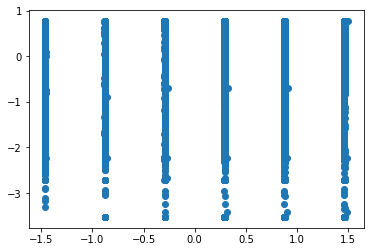

In [46]:
# Q1: The effects of further normalization
# Another normalization technique is to scale the variance of the data (z transform)

# scaling the variance would also be done on the subject level
data['pin_s'] = np.nan
data['time_s'] = np.nan

# for each subject, we compute the standart deviation and divide each value by it

subs = np.unique(data.subject)
for s in subs:
    
    data.loc[data.subject == s, 'pin_s'] = preprocessing.scale(data[data.subject == s]['pin_t'])#data[data.subject == s]['pin_c']/np.std(data[data.subject == s]['pin_c'])
    data.loc[data.subject == s, 'time_s'] = preprocessing.scale(data[data.subject == s]['time'])#data[data.subject == s]['time_c']/np.std(data[data.subject == s]['time_c'])
    
plt.scatter(data.time_s, data.pin_s);

In [47]:
sub = data.groupby('subject').describe()[['pin_c','pin_s']]
sub

pin_c                                                        \
          count          mean       std       min       25%       50%   
subject                                                                 
AD       7776.0  3.600729e-15  0.330695 -0.750814 -0.179233  0.182373   
AE       6120.0 -2.157715e-15  0.240773 -0.850552 -0.073606  0.149448   
AF       4290.0 -3.188592e-16  0.294984 -0.801466 -0.114482  0.187860   
AG       8196.0 -5.733551e-15  0.333676 -0.741859 -0.190650  0.177185   

                              pin_s                                    \
              75%       max   count          mean       std       min   
subject                                                                 
AD       0.249186  0.249186  7776.0 -4.329099e-15  1.000064 -2.270556   
AE       0.149448  0.149448  6120.0  1.288004e-17  1.000082 -3.532877   
AF       0.198534  0.198534  4290.0  8.135942e-16  1.000117 -2.717295   
AG       0.258141  0.258141  8196.0  6.625035e-16  1.000061 -2.223426   

                                                 
              25%       50%       75%       max  
subject                                          
AD      -0.542024  0.551518  0.753569  0.753569  
AE      -0.305730  0.620750  0.620750  0.620750  
AF      -0.388141  0.636922  0.673110  0.673110  
AG      -0.571397  0.531042  0.773674  0.773674

In [48]:
# Let's see if the model interpretation changes when the data is scaled

lmer_scaled = Lmer('rea_time ~ pin_s * time_s + (1+pin_s*time_s|subject)', data = data, family = 'gaussian')
lmer_scaledf = lmer_scaled.fit()

lmer_scaledf

boundary (singular) fit: see ?isSingular 

Formula: rea_time~pin_s*time_s+(1+pin_s*time_s|subject)

Family: gaussian	 Inference: parametric

Number of observations: 26382	 Groups: {'subject': 4.0}

Log-likelihood: -151835.244 	 AIC: 303670.488

Random effects:

                  Name       Var     Std
subject    (Intercept)  4694.162  68.514
subject          pin_s     1.358   1.165
subject         time_s     0.696   0.834
subject   pin_s:time_s    16.552   4.068
Residual                5835.850  76.393

                 IV1           IV2   Corr
subject  (Intercept)         pin_s  0.768
subject  (Intercept)        time_s -0.515
subject  (Intercept)  pin_s:time_s -0.977
subject        pin_s        time_s -0.944
subject        pin_s  pin_s:time_s -0.887
subject       time_s  pin_s:time_s  0.685

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),537.671,470.521,604.820,34.261,2.965,15.694,0.001,***
pin_s,-10.078,-11.569,-8.587,0.761,3.709,-13.248,0.000,***
time_s,2.143,0.893,3.394,0.638,3.942,3.360,0.029,*
pin_s:time_s,7.273,3.171,11.374,2.093,2.972,3.475,0.041,*


boundary (singular) fit: see ?isSingular 

Formula: rea_time~pin_c*time_c+(1+pin_c*time_c|subject)

Family: gaussian	 Inference: parametric

Number of observations: 26382	 Groups: {'subject': 4.0}

Log-likelihood: -151872.748 	 AIC: 303745.496

Random effects:

                  Name        Var      Std
subject    (Intercept)  11208.779  105.872
subject          pin_c   2372.853   48.712
subject         time_c      0.000    0.022
subject   pin_c:time_c    865.209   29.414
Residual                 5834.536   76.384

                 IV1           IV2   Corr
subject  (Intercept)         pin_c  0.225
subject  (Intercept)        time_c -0.221
subject  (Intercept)  pin_c:time_c -0.000
subject        pin_c        time_c -1.000
subject        pin_c  pin_c:time_c  0.001
subject       time_c  pin_c:time_c -0.001

Fixed effects:

In [49]:
lmer_centerf

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),537.666,433.910,641.423,52.938,0.353,10.157,0.299,
pin_c,-34.296,-82.154,13.563,24.418,20.107,-1.405,0.175,
time_c,0.008,-0.014,0.029,0.011,1.350,0.703,0.583,
pin_c:time_c,0.088,-28.738,28.913,14.707,2354.902,0.006,0.995,


Normalizing (aka dividing by) the standart deviation after centering DOES change the interpretation. 
I can't really explain why, but one reason why the z-transform is not applicable here might be that time is not normally distributed. Let's check if the model changes when I only normalize probability

In [50]:
lmer_pscaled = Lmer('rea_time ~ pin_s * time_c + (1+pin_s*time_c|subject)', data = data, family = 'gaussian')
lmer_pscaledf = lmer_pscaled.fit()

lmer_pscaledf

boundary (singular) fit: see ?isSingular 

Formula: rea_time~pin_s*time_c+(1+pin_s*time_c|subject)

Family: gaussian	 Inference: parametric

Number of observations: 26382	 Groups: {'subject': 4.0}

Log-likelihood: -151847.948 	 AIC: 303695.895

Random effects:

                  Name        Var      Std
subject    (Intercept)  12251.815  110.688
subject          pin_s      3.876    1.969
subject         time_c      0.000    0.004
subject   pin_s:time_c      0.001    0.024
Residual                 5836.332   76.396

                 IV1           IV2   Corr
subject  (Intercept)         pin_s  1.000
subject  (Intercept)        time_c -1.000
subject  (Intercept)  pin_s:time_c -0.998
subject        pin_s        time_c -1.000
subject        pin_s  pin_s:time_c -0.998
subject       time_c  pin_s:time_c  0.998

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),537.681,429.204,646.157,55.346,0.074,9.715,0.732,
pin_s,-10.176,-12.328,-8.024,1.098,0.083,-9.269,0.711,
time_c,0.008,0.002,0.013,0.003,0.101,2.770,0.752,
pin_s:time_c,0.026,0.002,0.050,0.012,0.073,2.141,0.819,


Yes, also when only probability is normalized, the results for the model are changed.

### This could have two reasons:
1. The shape of the distribution could change
2. The model might converge differently

To check if the shape of the distribtion changes, we compare the quantile-to-quantile plots

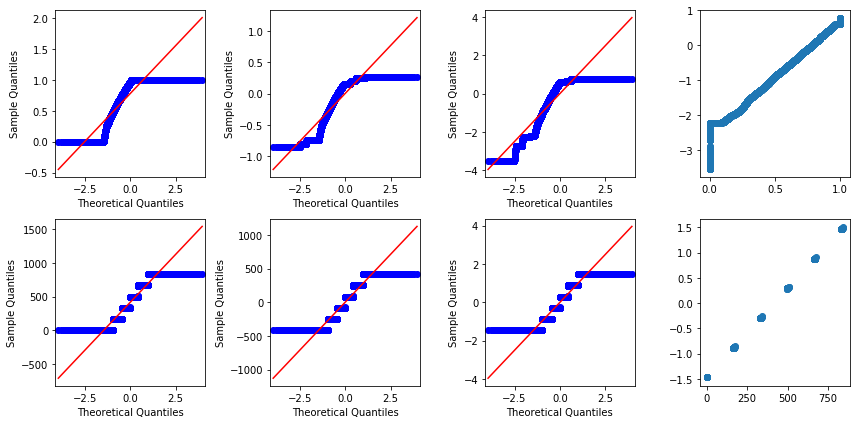

In [75]:
fig_qqplots, axsqq = plt.subplots(2,4, figsize = (12,6))

sm.qqplot(data.pin_t.values, line = 's', ax = axsqq[0,0]);
sm.qqplot(data.pin_c.values, line = 's', ax = axsqq[0,1]);
sm.qqplot(data.pin_s.values, line = 's', ax = axsqq[0,2]);
axsqq[0,3].scatter(np.sort(data.pin_t.values),np.sort(data.pin_s.values));

sm.qqplot(data.time.values, line = 's', ax = axsqq[1,0]);
sm.qqplot(data.time_c.values, line = 's', ax = axsqq[1,1]);
sm.qqplot(data.time_s.values, line = 's', ax = axsqq[1,2]);
axsqq[1,3].scatter(np.sort(data.time.values),np.sort(data.time_s.values));

plt.tight_layout()

In [53]:
rea_c = data.rea_time-np.mean(data.rea_time)
rea_s = rea_c/np.std(rea_c)

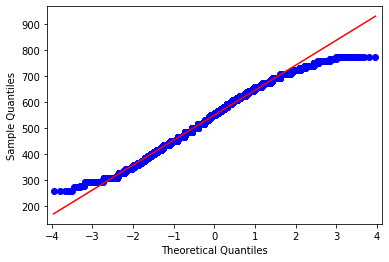

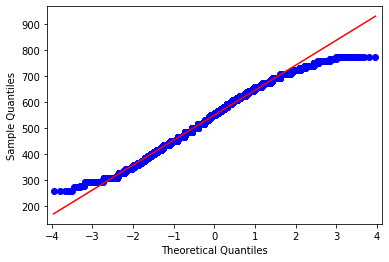

In [54]:
sm.qqplot(data.rea_time, line = 's')

Yes, normalizing can change the distribution slightly.

# since dividing the data by the standard deviation changes the distribution of the data, we won't do that. Instead, we will only apply linear scaling (centering to 0) 

Normalizing will be re-introduced later when we've taken care of model convergence.

#### Q2 which random slopes have to be included?
Background: including random slopes in a mixed effects model is comparable to fitting the data of each participant individually first, and then computing second-level analysis on the effects & the variance of the effects in each participant. 
Here, I have only 4 participants - computing the variance around each effect can be hard here. Also, the more effects I am trying to estimate, the more difficult it becomes for the model to converge well.

As an estimate of the the variance around our fixed effects, I will plot the effects fitted for each participant.

In [55]:
ADdat = data[data.subject == 'AD']
# fit the time model for this participant
lm_AD = Lm('rea_time ~time_c * pin_c', data = ADdat, family = 'gaussian')
lm_AD.fit();

AEdat = data[data.subject == 'AE']
# fit the time model for this participant
lm_AE = Lm('rea_time ~time_c * pin_c', data = AEdat, family = 'gaussian')
lm_AE.fit();

AFdat = data[data.subject == 'AF']
# fit the time model for this participant
lm_AF = Lm('rea_time ~time_c * pin_c', data = AFdat, family = 'gaussian')
lm_AF.fit();

AGdat = data[data.subject == 'AG']
# fit the time model for this participant
lm_AG = Lm('rea_time ~time_c * pin_c', data = AGdat, family = 'gaussian')
lm_AG.fit();


# and, as a comparison
lmer_ALL = Lmer('rea_time ~time_c * pin_c + (1+time_c*pin_c|subject)', data = data, family = 'gaussian')
lmer_ALL.fit();

Formula: rea_time~time_c*pin_c

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 7776	 R^2: 0.021	 R^2_adj: 0.021

Log-likelihood: -45489.450 	 AIC: 90986.899	 BIC: 91014.734

Fixed effects:

Formula: rea_time~time_c*pin_c

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 6120	 R^2: 0.034	 R^2_adj: 0.034

Log-likelihood: -34790.785 	 AIC: 69589.569	 BIC: 69616.447

Fixed effects:

Formula: rea_time~time_c*pin_c

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 4290	 R^2: 0.014	 R^2_adj: 0.014

Log-likelihood: -25789.414 	 AIC: 51586.827	 BIC: 51612.283

Fixed effects:

Formula: rea_time~time_c*pin_c

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 8196	 R^2: 0.020	 R^2_adj: 0.019

Log-likelihoo

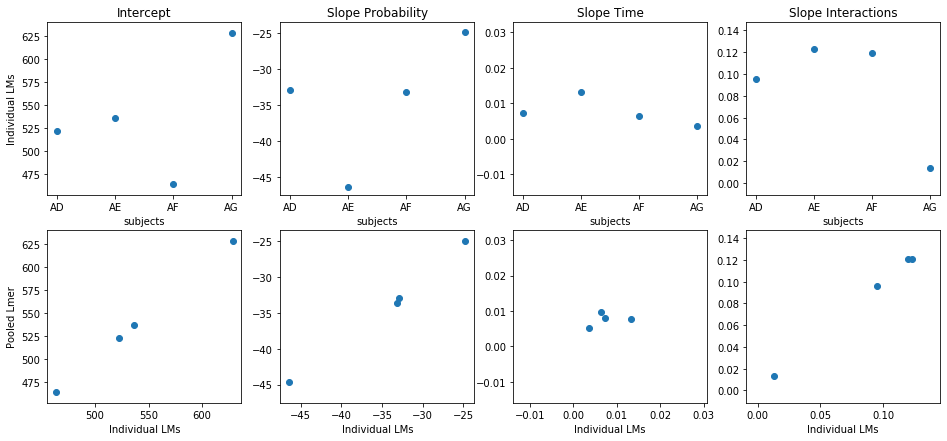

In [56]:
# plot all the effects (upper row individual lm, lower row all mixedlm)
fig_randomefs, axs12 = plt.subplots(2,4, figsize = (16,7), sharey = 'col')

# create vectors across all participant models
intercepts = [m.coefs.Estimate['Intercept'] for m in [lm_AD, lm_AE, lm_AF, lm_AG]]
pins = [m.coefs.Estimate['pin_c'] for m in [lm_AD, lm_AE, lm_AF, lm_AG]]
time = [m.coefs.Estimate['time_c'] for m in [lm_AD, lm_AE, lm_AF, lm_AG]]
interactions = [m.coefs.Estimate['time_c:pin_c'] for m in [lm_AD, lm_AE, lm_AF, lm_AG]]

# plot
axs12[0,0].scatter(['AD', 'AE', 'AF', 'AG'],intercepts)
axs12[0,1].scatter(['AD', 'AE', 'AF', 'AG'],pins)
axs12[0,2].scatter(['AD', 'AE', 'AF', 'AG'],time)
axs12[0,3].scatter(['AD', 'AE', 'AF', 'AG'],interactions)

# get vectors from lmer
intercepts_lmer = lmer_ALL.fixef['(Intercept)']
pins_lmer = lmer_ALL.fixef['pin_c']
time_lmer = lmer_ALL.fixef['time_c']
interactions_lmer = lmer_ALL.fixef['time_c:pin_c']

# plot
axs12[1,0].scatter(intercepts,intercepts_lmer)
axs12[1,1].scatter(pins,pins_lmer)
axs12[1,2].scatter(time,time_lmer)
axs12[1,3].scatter(interactions,interactions_lmer)

# set axis titles
axs12[0,0].set_title('Intercept')
axs12[0,1].set_title('Slope Probability')
axs12[0,2].set_title('Slope Time')
axs12[0,3].set_title('Slope Interactions')

axs12[0,0].set_ylabel('Individual LMs')
axs12[1,0].set_ylabel('Pooled Lmer');

axs12[0,0].set_xlabel('subjects')
axs12[0,1].set_xlabel('subjects')
axs12[0,2].set_xlabel('subjects')
axs12[0,3].set_xlabel('subjects')

axs12[1,0].set_xlabel('Individual LMs')
axs12[1,1].set_xlabel('Individual LMs')
axs12[1,2].set_xlabel('Individual LMs')
axs12[1,3].set_xlabel('Individual LMs')

fig_randomefs.tight_layout;

Yes, the random effects estimated by our mixed effects model are highly comparable to the individually fitted linear models 

We only have a limited number of participants here (4). Thus, we can only fit a limited number of random effects. Otherwise, the model might not converge. In fact, with only 4 participants we might already expect the model not to merge with and random effect other than intercept. 

Nevertheless, we will fit 2 models: one with only the intercept, and one with the intercept and 2 main effects.

In [58]:
lmer_randInt = Lmer('rea_time ~ time_c * pin_c + (1|subject)', data = data, family = 'gaussian')
results_randInt = lmer_randInt.fit()
print(results_randInt)

lmer_randMain = Lmer('rea_time ~ time_c * pin_c + (1+time_c+pin_c|subject)', data = data, family = 'gaussian')
results_randMain = lmer_randMain.fit()
print(results_randMain)

Formula: rea_time~time_c*pin_c+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 26382	 Groups: {'subject': 4.0}

Log-likelihood: -151881.109 	 AIC: 303762.219

Random effects:

                 Name       Var     Std
subject   (Intercept)  4587.889  67.734
Residual               5852.816  76.504

No random effect correlations specified

Fixed effects:

              Estimate   2.5_ci  97.5_ci      SE         DF  T-stat  P-val  \
(Intercept)    537.879  471.494  604.264  33.871      3.000  15.880  0.001   
time_c           0.007    0.004    0.010   0.002  26375.000   4.047  0.000   
pin_c          -32.481  -35.593  -29.369   1.588  26375.000 -20.459  0.000   
time_c:pin_c     0.075    0.064    0.086   0.006  26375.011  13.452  0.000   

              Sig  
(Intercept)   ***  
time_c        ***  
pin_c         ***  
time_c:pin_c  ***  
boundary (singular) fit: see ?isSingular 

Formula: rea_time~time_c*pin_c+(1+time_c+pin_c|subject)

Family: gaussian	 Inferen

#### Understanding Degrees of Freedom
Lmer computes it's degrees of freedom like this:
https://en.wikipedia.org/wiki/Welch%E2%80%93Satterthwaite_equation

In [59]:
print("The AIC of the random intercept model was: {}, the AIC of the random main effects model was {}".format(lmer_randInt.AIC,lmer_randMain.AIC))

The AIC of the random intercept model was: 303762.2185610203, the AIC of the random main effects model was 303764.9724043985


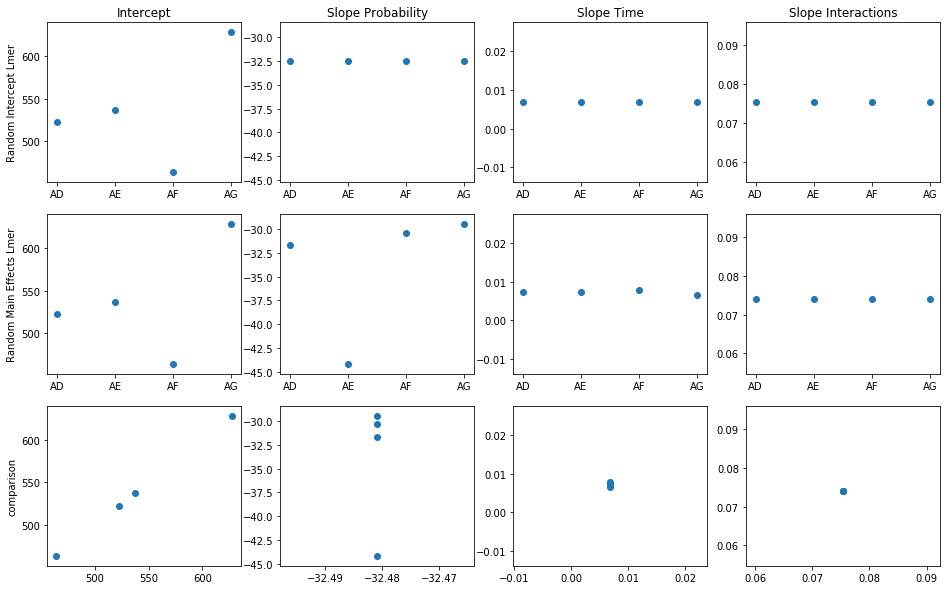

In [60]:
# compare the results from the intercept only model and the main effect model
fig_randomefs_modelcomp, axs13 = plt.subplots(3,4, figsize = (16,10), sharey = 'col')
subs = ['AD', 'AE', 'AF', 'AG']

# get vectors from random intercept lmer
intercepts_randint = lmer_randInt.fixef['(Intercept)']
pins_randint = lmer_randInt.fixef['pin_c']
time_randint = lmer_randInt.fixef['time_c']
interactions_randint = lmer_randInt.fixef['time_c:pin_c']

# get vectors from random main effects lmer
intercepts_randmain = lmer_randMain.fixef['(Intercept)']
pins_randmain = lmer_randMain.fixef['pin_c']
time_randmain = lmer_randMain.fixef['time_c']
interactions_randmain = lmer_randMain.fixef['time_c:pin_c']

# plot random intercept
axs13[0,0].scatter(subs,intercepts_randint)
axs13[0,1].scatter(subs,pins_randint)
axs13[0,2].scatter(subs,time_randint)
axs13[0,3].scatter(subs,interactions_randint)

# plot random main effects
axs13[1,0].scatter(subs,intercepts_randmain)
axs13[1,1].scatter(subs,pins_randmain)
axs13[1,2].scatter(subs,time_randmain)
axs13[1,3].scatter(subs,interactions_randmain)

# plot comparison
axs13[2,0].scatter(intercepts_randint,intercepts_randmain)
axs13[2,1].scatter(pins_randint,pins_randmain)
axs13[2,2].scatter(time_randint,time_randmain)
axs13[2,3].scatter(interactions_randint,interactions_randmain)


# set axis titles
axs13[0,0].set_title('Intercept')
axs13[0,1].set_title('Slope Probability')
axs13[0,2].set_title('Slope Time')
axs13[0,3].set_title('Slope Interactions')

axs13[0,0].set_ylabel('Random Intercept Lmer')
axs13[1,0].set_ylabel('Random Main Effects Lmer')
axs13[2,0].set_ylabel('comparison')

fig_randomefs_modelcomp.tight_layout;

I don't trust the main effect of time. Since I can demonstrate that the distribution of reaction times is the same over all time points, my best guess is that parts of the interaction between time and probability are not captured in the model and the left-over variance is explained by the main effect.

This can happen when the relationship between the predictors and the reaction time is not linear, but of higher order.

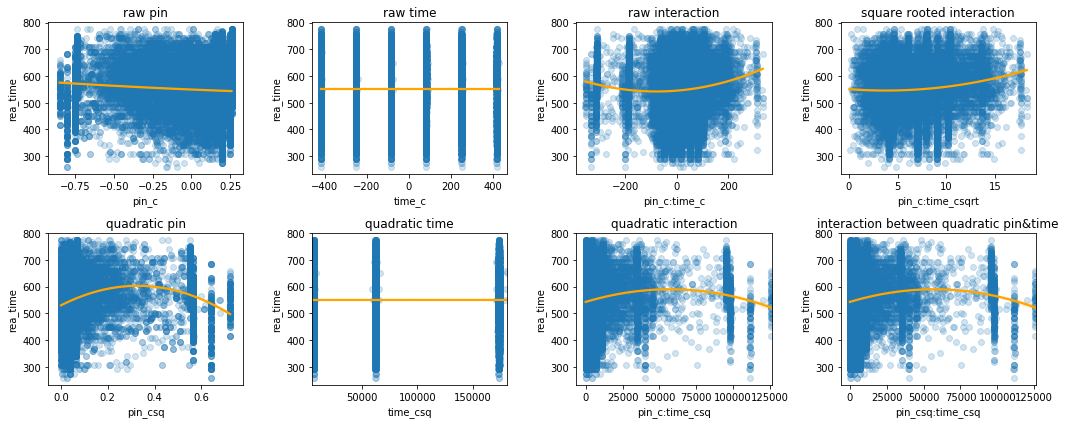

In [61]:
fig_orders, axs14 = plt.subplots(2,4, figsize = (15,6))

sns.regplot(x = 'pin_c', y = 'rea_time', data = data, order = 2, line_kws = {'color' : 'orange'}, scatter_kws = {'alpha': 0.2}, ax = axs14[0,0])
sns.regplot(x = 'time_c', y = 'rea_time', data = data, order = 2, line_kws = {'color' : 'orange'}, scatter_kws = {'alpha': 0.2}, ax = axs14[0,1])

#interaction term
data['pin_c:time_c'] = data.pin_c*data.time_c

sns.regplot(x = 'pin_c:time_c', y = 'rea_time', data = data, order = 2, line_kws = {'color' : 'orange'}, scatter_kws = {'alpha': 0.2}, ax = axs14[0,2])

# square rooted interaction term
data['pin_c:time_csqrt'] = data['pin_c:time_c']**(1/float(2))
sns.regplot(x = 'pin_c:time_csqrt', y = 'rea_time', data = data, order = 2, line_kws = {'color' : 'orange'}, scatter_kws = {'alpha': 0.2}, ax = axs14[0,3])


# squared pin_c and time_c
data['pin_csq'] = data.pin_c**2
data['time_csq'] = data.time_c**2

sns.regplot(x = 'pin_csq', y = 'rea_time', data = data, order = 2, line_kws = {'color' : 'orange'}, scatter_kws = {'alpha': 0.2}, ax = axs14[1,0])
sns.regplot(x = 'time_csq', y = 'rea_time', data = data, order = 2, line_kws = {'color' : 'orange'}, scatter_kws = {'alpha': 0.2}, ax = axs14[1,1])

# squared interaction term
data['pin_c:time_csq'] = data['pin_c:time_c']**2
sns.regplot(x = 'pin_c:time_csq', y = 'rea_time', data = data, order = 2, line_kws = {'color' : 'orange'}, scatter_kws = {'alpha': 0.2}, ax = axs14[1,2])

# interaction of squared terms
data['pin_csq:time_csq'] = data['pin_csq']*data['time_csq']
sns.regplot(x = 'pin_csq:time_csq', y = 'rea_time', data = data, order = 2, line_kws = {'color' : 'orange'}, scatter_kws = {'alpha': 0.2}, ax = axs14[1,3])

# set titles
axs14[0,0].set_title('raw pin')
axs14[0,1].set_title('raw time')
axs14[0,2].set_title('raw interaction')
axs14[0,3].set_title('square rooted interaction')

axs14[1,0].set_title('quadratic pin')
axs14[1,1].set_title('quadratic time')
axs14[1,2].set_title('quadratic interaction')
axs14[1,3].set_title('interaction between quadratic pin&time')


fig_orders.tight_layout();

In [62]:
lmer_quadMain = Lmer('rea_time ~ time_c * pin_c + time_csq + pin_csq + (1|subject)', data = data, family = 'gaussian')
results_quadMain = lmer_quadMain.fit()
print(results_quadMain)


lmer_quadInt = Lmer('rea_time ~ time_c * pin_c + time_csq * pin_csq + (1|subject)', data = data, family = 'gaussian')
results_quadInt = lmer_quadInt.fit()
print(results_quadInt)

Formula: rea_time~time_c*pin_c+time_csq+pin_csq+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 26382	 Groups: {'subject': 4.0}

Log-likelihood: -151822.447 	 AIC: 303644.894

Random effects:

                 Name       Var     Std
subject   (Intercept)  4675.382  68.377
Residual               5823.641  76.313

No random effect correlations specified

Fixed effects:

              Estimate   2.5_ci  97.5_ci      SE         DF  T-stat  P-val  \
(Intercept)    547.064  480.029  614.100  34.202      3.004  15.995  0.001   
time_c           0.016    0.012    0.019   0.002  26373.149   8.448  0.000   
pin_c          -61.235  -67.173  -55.297   3.030  26373.553 -20.212  0.000   
time_csq        -0.000   -0.000   -0.000   0.000  26373.011  -5.072  0.000   
pin_csq        -67.831  -80.068  -55.594   6.243  26373.733 -10.864  0.000   
time_c:pin_c     0.066    0.054    0.077   0.006  26373.019  11.251  0.000   

              Sig  
(Intercept)   ***  
time_c      

In [63]:
x = lmer_ALL.ranef_var
print(x)

                  Name          Var        Std
subject    (Intercept)  8775.836625  93.679435
subject         time_c     0.000006   0.002488
subject          pin_c  1758.167713  41.930511
subject   time_c:pin_c  1489.751603  38.597300
Residual                5835.354602  76.389493


In [64]:
# Q3 compare python statsmodels to Lmer



In [65]:
# the scaled model



### martin suggestion: linearizing pin

In [66]:
#plt.scatter(data.time_c,data.pin_c, alpha = 0.01)

In [67]:
#sum_pin_c = data.groupby('time_c').describe().pin_c

#plt.scatter(sum_pin_c.index, sum_pin_c['mean'])

In [68]:
#sum_pin_c.mean